In [1]:
import numpy as np 
import pandas as pd 

#for pre-processing
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('punkt')

#for model training

from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
test_data = pd.read_csv("test_set.tsv",sep='\t', encoding='ISO-8859-1')

In [16]:
training_data = pd.read_csv("training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1',
                            usecols = ['essay_id', 'essay_set', 'essay','domain1_score']).dropna(axis=1)

In [17]:
scores = training_data['domain1_score']

In [18]:
test_data.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,NaN
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,NaN
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,NaN
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,NaN
4,2387,1,"Dear Local newspaper, I think that people have...",2387,NaN


In [19]:
test_data.shape

(4254, 5)

In [20]:
training_data.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [21]:
training_data.shape

(12976, 4)

In [22]:
test_data.dropna(axis=1,inplace=True)

In [23]:

y = training_data['domain1_score']
X = training_data.copy()


In [24]:
def essay_to_wordlist(essay_v, remove_stopwords):
    #Remove the tagged labels and word tokenize the sentence.
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make ar from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [25]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [26]:
cv = KFold(n_splits = 8, shuffle = True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300
    min_word_count = 40
    num_workers = 8
    context = 10
    downsampling = 1e-3

    
    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=2)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    
    # Save any one of the 5 models.
    if count == 5:
         lstm_model.save_weights('final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1    


--------Fold 1--------

Training Word2Vec Model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
178/178 [==============================] - 34s 26ms/step - loss: 80.0289 - mae: 5.0009
Epoch 2/2
178/178 [==============================] - 5s 26ms/step - loss: 42.6830 - mae: 3.6584
Kappa Score: 0.7903575237442636

--------Fold 2--------

In [27]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.7709


In [28]:
# Splitting dataset into training and test set and generating word embeddings for other models other than
# neural networks

indep_train, indep_test, dep_train, dep_test = train_test_split(X, scores, test_size = 0.25)

train_essays2 = indep_train['essay']
test_essays2 = indep_test['essay']
    
sentences2 = []


for essay2 in train_essays2:
            # Obtaining all sentences from the training set of essays.
            sentences2 += essay_to_sentences(essay2,remove_stopwords = True)
            
# Initializing variables for word2vec model.
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

clean_train_essays2 = []
    
# Generate training and testing data word vectors.
for essay_text2 in train_essays2:
    clean_train_essays2.append(essay_to_wordlist(essay_text2,remove_stopwords = True))
trainDataVecs2 = getAvgFeatureVecs(clean_train_essays2, model, num_features)
    
clean_test_essays2 = []
for essay_text2 in test_essays2:
    clean_test_essays2.append(essay_to_wordlist(essay_text2,remove_stopwords = True))
testDataVecs2 = getAvgFeatureVecs(clean_test_essays2, model, num_features)
    
trainDataVecs2 = np.array(trainDataVecs2)
testDataVecs2 = np.array(testDataVecs2)

Training Word2Vec Model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [29]:
# Generating scores using Linear Regression Model

linear_regressor = LinearRegression()

linear_regressor.fit(trainDataVecs2, dep_train)

dep_pred = linear_regressor.predict(testDataVecs2)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

#print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(dep_pred, dep_test))
print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

Mean squared error: 20.85
Variance score: 0.72
Kappa Score: 0.85


In [ ]:
ksr = ("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

In [30]:
#Generating scores using Gradient Boosting regressor

'''from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[100, 1000], 'max_depth':[2], 'min_samples_split': [2],
          'learning_rate':[3, 1, 0.1, 0.3], 'loss': ['ls']}

gbr = ensemble.GradientBoostingRegressor()

grid = GridSearchCV(gbr, params)
grid.fit(trainDataVecs2, dep_train)

y_pred = grid.predict(testDataVecs2)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)'''

#USING THE PARAMS FOUND OUT USING GRID SEARCH CV
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
gbr.fit(trainDataVecs2, dep_train)
dep_pred = gbr.predict(testDataVecs2)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


Mean squared error: 9.14
Variance score: 0.88
Kappa Score: 0.94


In [31]:
# Generating scores using Support Vector Regression
svr = SVR()

'''parameters = {'kernel':['linear', 'rbf'], 'C':[1, 100], 'gamma':[0.1, 0.001]}

grid = GridSearchCV(svr, parameters)
grid.fit(trainDataVecs2, dep_train)

y_pred = grid.predict(testDataVecs2)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)'''

#USING THE PARAMS FOUND OUT USING GRID SEARCH CV
svr = SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr.fit(trainDataVecs2, dep_train)
dep_pred = svr.predict(testDataVecs2)


# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

#Cohen's Kappa score
print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

Mean squared error: 34.61
Variance score: 0.55
Kappa Score: 0.65


In [32]:
# Generating scores using XGBClassifier
from xgboost import XGBClassifier
xgb=XGBClassifier(colsample_bytree=0.4,gamma=0,learning_rate=0.01,max_depth=4,min_child_weight=0.5,n_estimators=100,                                                                    reg_alpha=0.75,reg_lambda=0.45,
                 subsample=0.6,seed=42)
xgb.fit(trainDataVecs2, dep_train)
dep_pred = xgb.predict(testDataVecs2)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

#print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(dep_pred, dep_test))
print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

Mean squared error: 17.12
Variance score: 0.77
Kappa Score: 0.88


In [33]:
# Generating scores using Logistic Regression
lr = LogisticRegression(random_state=1, max_iter=1000)
lr.fit(trainDataVecs2, dep_train)
dep_pred = lr.predict(testDataVecs2)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

#print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(dep_pred, dep_test))
print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

Mean squared error: 40.63
Variance score: 0.48
Kappa Score: 0.66


In [34]:
# Generating scores using K-Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(trainDataVecs2, dep_train)
dep_pred = knn.predict(testDataVecs2)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

#print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(dep_pred, dep_test))
print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))


Mean squared error: 15.10
Variance score: 0.81
Kappa Score: 0.91


In [35]:
# Generating scores using Desion Tree Classifier
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 30)
dt.fit(trainDataVecs2, dep_train)
dep_pred = dt.predict(testDataVecs2)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

#print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(dep_pred, dep_test))
print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

Mean squared error: 21.12
Variance score: 0.72
Kappa Score: 0.86


In [36]:
# Generating scores using Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=12)
rf.fit(trainDataVecs2, dep_train)
dep_pred = rf.predict(testDataVecs2)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(dep_test, dep_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % explained_variance_score(dep_test,dep_pred))

#print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(dep_pred, dep_test))
print("Kappa Score: {0:.2f}".format(cohen_kappa_score(dep_test.values,np.around(dep_pred),weights='quadratic')))

Mean squared error: 10.44
Variance score: 0.86
Kappa Score: 0.93


**Comparison of Kappa Score of different algorithms**

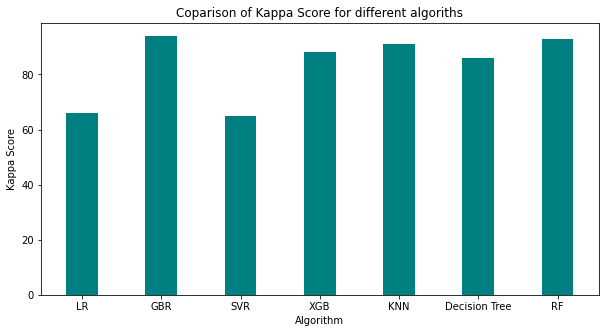

In [104]:


import numpy as np
import matplotlib.pyplot as plt

data = {'LR': 85, 'GBR': 94, 'SVR': 65, 'XGB':88, 'LR':66, 'KNN':91,'Decision Tree':86, 'RF':93  }
courses = list(data.keys())
values = list(data.values())
 
ks =[ks_lr, ks_gb]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='teal',width = 0.4)
 
plt.xlabel("Algorithm")
plt.ylabel("Kappa Score")
plt.title("Coparison of Kappa Score for different algoriths")
plt.show()

* Gradient Boosting regressor gives highest cohen kappa score (0.95) 
* We made our final prediction with Gradient Boosting Regressor Model

## Prediction by best Model

In [ ]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
gbr.fit(trainDataVecs2, dep_train)
predicted_scores = gbr.predict(testDataVecs2)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


In [ ]:
predicted_score = predicted_scores
# predicted_score = pd.Series([score for sublist in predicted_scores for score in sublist])
predicted_score=pd.DataFrame(predicted_score,columns=['Predicted_Score']).round()
predicted_score.head()

,Predicted_Score
0,3.0
1,2.0
2,3.0
3,2.0
4,16.0


In [37]:
final_scores = pd.concat([test_data, predicted_score], axis = 1).rename(columns = {0:"predicted_score"})


NameError: ignored

In [ ]:
final_scores.head()